In [31]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob as glob
import json

In [33]:
mininet_root = "./data/mininet_experiments/2020-10-23_10-47-36/"

def build_file_list(directory,clip=None):
    '''
    Given a direction of mininet data with the following format
    
    root
    +----experiment
              |
              +---run #--+
                         |
                         +--desc.json
                         +--pub_results.csv
                         +--sub_results.csv
    
    Descend the tree and for each leaf subdiretory and 
    return a dictionary with the following:
    - experiment - the experiment name
    - run - the run name
    - json - the description json file
    - pub_csv - the pub csv file
    - sub_csv - the sub csv file
    
    The method returns a list of dictionaries with these values.
    '''
    ret_val = [] 
    files = glob.glob(directory+"*",recursive=True)
    print("TOTAL DIRECTORIES {0}".format(len(files)))
    for idx, dir_name in enumerate(files):
        if clip is not None and idx > clip:
            break
        file_set = {}
        runs = glob.glob(dir_name+"/*",recursive=True)
        for run in runs:
            values = run.split("/")
            file_set = {}
            file_set["experiment"] = values[-2]
            file_set["run"] = values[-1]
            test = glob.glob(run+"/*",recursive=True)
            for t in test:
                if t.find(".json") >= 0:
                    file_set["json"] = t
                if t.find("pub_log") >= 0 :
                    file_set["pub_csv"] = t
                if t.find("sub_log") >= 0 :
                    file_set["sub_csv"] = t                
            ret_val.append(file_set)
    return ret_val
file_list = build_file_list(mininet_root)
print("Total files to process is 3x{0} = {1}".format(len(file_list),3*len(file_list)))


TOTAL DIRECTORIES 90
Total files to process is 3x900 = 2700


In [34]:
def process_mininet_test(json_file,pub_file,sub_file):
    """
    For a Mininet experiment there are three files:
    a publisher csv, a subscriber csv, and a json description file
    
    This method takes in all three files, processes the CSV files into summary
    statistics, and prepends either "pub_" or "sub_" to each data column summary. The results
    are all placed into a single dictionary along with the json file contents and returned.
    """
    result = {}
    result["json_fname"] = json_file
    with open(json_file,"r") as fptr:
        result.update(json.load(fptr))
    result.update(collapse_csv_file(pub_file,"pub_"))
    result.update(collapse_csv_file(sub_file,"sub_"))
    result["lost_prct"] = 100.0*result["sub_sum_lost"]/result["pub_sum_sent"]    
    return result

def collapse_csv_file(csv_file,prefix):
    """
    This method takes in a mininet CSV file and "summarizes" it. 
    
    To do this we 
    
    - Load the CSV
    - prepend "mean_" and "pub_" or "sub_" to each column. 
    - remove the nans 
    - take each column in the input file and calculate its mean
    - calculate the total packets sent, received, and lost 
    
    - toss all these numbers in a dictionary and return the results.
    """
    df = pd.read_csv(csv_file,header=21,na_values=["inf","-inf","-nan","nan","NaN"])
    new_cols = [prefix+"mean_"+c.strip("\t") for c in df.columns]
    df.columns = new_cols
    df = df.fillna(0)
    ret_val = df.mean().to_dict()
    # A lot more metric extraction could go here but for now just take the column means
    # df = df.replace([np.inf, -np.inf, np.nan],0)
    # these values aren't the mean, it is just the name
    ret_val[prefix+"sum_sent"] = df[prefix+"mean_"+"sent"].sum()
    ret_val[prefix+"sum_recv"] = df[prefix+"mean_"+"received"].sum()
    ret_val[prefix+"sum_lost"] = df[prefix+"mean_"+"lost"].sum()
    return ret_val

def process_mininet_dataset(file_list):
    """
    Given a list of dictionaries with the json and csv files for a 
    mininet run go through the list and process each file summarizing the
    results as a new dictionary. The resulting list of dictionaries
    can be dropped into a pandas dataframe for easier handling. 
    
    """
    ret_val = []
    i = 0
    for f in file_list:
        if len(f.keys()) != 5:
            print( "Ignoring: {0}".format(f))
            continue # dead simple validity check as there are some config files
        i += 1
        out = process_mininet_test(f["json"],f["pub_csv"],f["sub_csv"])
        out["experiment"] = f["experiment"]
        out["run"] = f["run"]
        if i%150==0:
            print(i,f)
        ret_val.append(out)
    print("Total complete {0}".format(len(ret_val)))
    return  pd.DataFrame(ret_val).fillna(0)
    
print("Processing {0} files.".format(len(file_list)))
df = process_mininet_dataset(file_list)
df.head()
df.to_csv("MininetResults.csv")

Processing 900 files.
150 {'experiment': 'rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_1000bw_10loss_0delay', 'run': 'run06', 'pub_csv': './data/mininet_experiments/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_1000bw_10loss_0delay/run06/pub_log_PointCloud512k_23-10-2020_13-02-35', 'json': './data/mininet_experiments/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_1000bw_10loss_0delay/run06/experiment_config.json', 'sub_csv': './data/mininet_experiments/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_PointCloud512k@30_reliable_volatile_keep_last@10_1000bw_10loss_0delay/run06/sub_log_PointCloud512k_23-10-2020_13-02-35'}
300 {'experiment': 'rmw_fastrtps_cpp_async_Array1k@30_reliable_volatile_keep_last@10_54bw_10loss_0delay', 'run': 'run06', 'json': './data/mininet_experiments/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_Array1k@30_reliable_volatile_keep_last@10_54bw_10loss_0delay

In [35]:
df.head()


,json_fname,rmw_implementation,async_pub,bandwidth,loss,delay,message_rate,message_type,reliability,durability,...,sub_mean_cpu_usage (%),sub_sum_sent,sub_sum_recv,sub_sum_lost,lost_prct,experiment,run,sub_mean_latency_min (ms),sub_mean_latency_max (ms),sub_mean_latency_variance (ms)
0,./data/mininet_experiments/2020-10-23_10-47-36...,rmw_fastrtps_cpp,sync,54,40,0,30,Array1k,reliable,volatile,...,0.136686,0,0,0,0.0,rmw_fastrtps_cpp_sync_Array1k@30_reliable_vola...,run10,0.0,0.0,0.0
1,./data/mininet_experiments/2020-10-23_10-47-36...,rmw_fastrtps_cpp,sync,54,40,0,30,Array1k,reliable,volatile,...,0.191593,0,0,0,0.0,rmw_fastrtps_cpp_sync_Array1k@30_reliable_vola...,run02,0.0,0.0,0.0
2,./data/mininet_experiments/2020-10-23_10-47-36...,rmw_fastrtps_cpp,sync,54,40,0,30,Array1k,reliable,volatile,...,0.244935,0,0,0,0.0,rmw_fastrtps_cpp_sync_Array1k@30_reliable_vola...,run07,0.0,0.0,0.0
3,./data/mininet_experiments/2020-10-23_10-47-36...,rmw_fastrtps_cpp,sync,54,40,0,30,Array1k,reliable,volatile,...,0.240545,0,0,0,0.0,rmw_fastrtps_cpp_sync_Array1k@30_reliable_vola...,run05,0.0,0.0,0.0
4,./data/mininet_experiments/2020-10-23_10-47-36...,rmw_fastrtps_cpp,sync,54,40,0,30,Array1k,reliable,volatile,...,0.142169,0,0,0,0.0,rmw_fastrtps_cpp_sync_Array1k@30_reliable_vola...,run08,0.0,0.0,0.0


In [36]:
print("RMW in set:")
print(df.rmw_implementation.unique())
print("Bandwidth in set:")
print(df.bandwidth.unique())
print("Loss set:")
print(df.loss.unique())
print("Delay set:")
print(df.delay.unique())
print("Mode set:")
print(df.async_pub.unique())
print("Message rate set:")
print(df.message_rate.unique())
print("Message type set:")
print(df.message_type.unique())
# Break our huge dataset down by vendor and sync/async
cyclone_df = df[df["rmw_implementation"]=="rmw_cyclonedds_cpp"]
fast_df = df[df["rmw_implementation"]=="rmw_fastrtps_cpp"]
fast_sync_df = fast_df[fast_df["async_pub"] == "sync"]
fast_async_df = fast_df[fast_df["async_pub"] == "async"]

RMW in set:
['rmw_fastrtps_cpp' 'rmw_cyclonedds_cpp']
Bandwidth in set:
[  54 1000  300]
Loss set:
[40 30 20  0 10]
Delay set:
[0]
Mode set:
['sync' 'async']
Message rate set:
[30]
Message type set:
['Array1k' 'PointCloud512k']


In [37]:
def slice_mininet_data_bw_loss(vendor_df, dep_variable,msg_rate,msg_type):
    temp = vendor_df[vendor_df["message_rate"] == msg_rate ]
    temp = temp[temp["message_type"] == msg_type ]
    print(len(temp))

slice_mininet_data_bw_loss(fast_df,None,100,"Array1m")

0


In [38]:
# Count the experiments with average latency or loss > 0 
print("Fast sync experiments with loss > 0 : {0} of {1}".format(len(fast_sync_df[fast_sync_df['lost_prct']>0]),len(fast_sync_df)))
print("Fast async experiments with loss > 0 : {0} of {1}".format(len(fast_async_df[fast_async_df['lost_prct']>0]),len(fast_async_df)))
print("Cyclone experiments with loss > 0 {0} of {1}".format(len(cyclone_df[cyclone_df['lost_prct']>0]),len(cyclone_df)))
print("Fast sync experiments with latency > 0 : {0} of {1}".format(len(fast_sync_df[fast_sync_df['sub_mean_latency_max (ms)']>0]),len(fast_sync_df)))
print("Fast async experiments with latency > 0 : {0} of {1}".format(len(fast_async_df[fast_async_df['sub_mean_latency_max (ms)']>0]),len(fast_async_df)))
print("Cyclone experiments with latency > 0: {0} of {1}".format(len(cyclone_df[cyclone_df["sub_mean_latency_max (ms)"]>0]),len(cyclone_df)))


Fast sync experiments with loss > 0 : 99 of 300
Fast async experiments with loss > 0 : 103 of 300
Cyclone experiments with loss > 0 91 of 300
Fast sync experiments with latency > 0 : 78 of 300
Fast async experiments with latency > 0 : 78 of 300
Cyclone experiments with latency > 0: 99 of 300


In [39]:
print(fast_df.columns)

Index(['json_fname', 'rmw_implementation', 'async_pub', 'bandwidth', 'loss',
       'delay', 'message_rate', 'message_type', 'reliability', 'durability',
       'history_kind', 'history_depth', 'pub_mean_T_experiment',
       'pub_mean_T_loop', 'pub_mean_received', 'pub_mean_sent',
       'pub_mean_lost', 'pub_mean_relative_loss', 'pub_mean_data_received',
       'pub_mean_latency_mean (ms)', 'pub_mean_latency_variance (ms)',
       'pub_mean_pub_loop_res_min (ms)', 'pub_mean_pub_loop_res_max (ms)',
       'pub_mean_pub_loop_res_mean (ms)',
       'pub_mean_pub_loop_res_variance (ms)',
       'pub_mean_sub_loop_res_mean (ms)',
       'pub_mean_sub_loop_res_variance (ms)', 'pub_mean_ru_utime',
       'pub_mean_ru_stime', 'pub_mean_ru_maxrss', 'pub_mean_ru_ixrss',
       'pub_mean_ru_idrss', 'pub_mean_ru_isrss', 'pub_mean_ru_minflt',
       'pub_mean_ru_majflt', 'pub_mean_ru_nswap', 'pub_mean_ru_inblock',
       'pub_mean_ru_oublock', 'pub_mean_ru_msgsnd', 'pub_mean_ru_msgrcv',
       'p

In [40]:
def average_experimental_runs(df):
    """
    Each experiment has ten runs, for each experiment in a dataframe
    grab the description of the the experiment, and the mean and std 
    for a few key perameters and return a new dataframe. 
    """
    # total unique experiments
    experiments = df["experiment"].unique()
    result = [] 
    # plotting info
    desc_cols = ['rmw_implementation', 'bandwidth', 'loss', 'delay',
       'message_rate', 'message_type', 'reliability', 'durability',
       'history_kind', 'history_depth']
    for experiment in experiments:
        temp = {}
        run = df[df["experiment"]==experiment]
        for d in desc_cols:
            temp[d] = run.iloc[0][d]
        # values we want to calculate mean and std for. 
        to_keep = ["sub_mean_latency_max (ms)","lost_prct","sub_mean_latency_mean (ms)"]
        for keep in to_keep:
            temp[keep] = run[keep].mean()
            temp[keep+"_min"] = np.min(run[keep])
            temp[keep+"_max"] = np.max(run[keep])
        result.append(temp)
    return pd.DataFrame(data=result)
        
cyclone_run_avg_df = average_experimental_runs(cyclone_df)
fast_sync_run_avg_df = average_experimental_runs(fast_sync_df)
fast_async_run_avg_df = average_experimental_runs(fast_async_df)


In [41]:
print("Avg Fast sync experiments with loss > 0 : {0} of {1}".format(len(fast_sync_run_avg_df[fast_sync_run_avg_df['lost_prct']>0]),len(fast_sync_run_avg_df)))
print("Avg Fast async experiments with loss > 0 : {0} of {1}".format(len(fast_async_run_avg_df[fast_async_run_avg_df['lost_prct']>0]),len(fast_async_run_avg_df)))
print("Avg Cyclone experiments with loss > 0 : {0} of {1}".format(len(cyclone_run_avg_df[cyclone_run_avg_df['lost_prct']>0]),len(cyclone_run_avg_df)))
print("Avg Fast sync experiments with latency > 0 : {0} of {1}".format(len(fast_sync_run_avg_df[fast_sync_run_avg_df['sub_mean_latency_max (ms)']>0]),len(fast_sync_run_avg_df)))
print("Avg Fast async experiments with latency > 0 : {0} of {1}".format(len(fast_async_run_avg_df[fast_async_run_avg_df['sub_mean_latency_max (ms)']>0]),len(fast_async_run_avg_df)))
print("Avg Cyclone experiments with latency > 0: {0} of {1}".format(len(cyclone_run_avg_df[cyclone_run_avg_df["sub_mean_latency_max (ms)"]>0]),len(cyclone_run_avg_df)))


Avg Fast sync experiments with loss > 0 : 15 of 30
Avg Fast async experiments with loss > 0 : 14 of 30
Avg Cyclone experiments with loss > 0 : 19 of 30
Avg Fast sync experiments with latency > 0 : 11 of 30
Avg Fast async experiments with latency > 0 : 11 of 30
Avg Cyclone experiments with latency > 0: 12 of 30


In [42]:
def print_failed_experiments(value,cutoff,name,df):
    """
    Given a dataframe find values that meet a certain criteria (like latency or loss) 
    and print the conditions where that happens. Also return the experimental conditions that cause it
    
    value -- the value to check
    cutoff -- the maximum value
    name -- the name to print
    df -- the dataframe with the mininet data
    """
    to_plot = []
    temp = cyclone_run_avg_df[cyclone_run_avg_df[value]>cutoff]
    for i in range(0,len(temp)):
        print(name + " with average magnitude: {0} for BW{1}-L{2}-R{3}".format(temp.iloc[i][value],temp.iloc[i].bandwidth,temp.iloc[i].loss,temp.iloc[i].message_rate,temp.iloc[i].message_type))
        sample = (temp.iloc[i].bandwidth,
                  temp.iloc[i].loss,
                  temp.iloc[i].message_type)
        to_plot.append(sample)
    print("----------------")
    return to_plot

# Now, for every vendor or flavor of vendor, find any experiment where the average latency > 30m or
# every experiment where more than one packet was lost. IF any RMW experiment has these conditions
# we'll plot all of them.

loss_cutoff = 1
to_plot = print_failed_experiments('lost_prct',loss_cutoff,"Fast Sync lost packets",fast_sync_run_avg_df)
to_plot += print_failed_experiments('lost_prct',loss_cutoff,"Fast Async lost packets",fast_async_run_avg_df)
to_plot += print_failed_experiments('lost_prct',loss_cutoff,"Cyclone lost packets",cyclone_run_avg_df)

latency_cutoff = 30
to_plot += print_failed_experiments('sub_mean_latency_mean (ms)',latency_cutoff,"Fast Sync latency",fast_sync_run_avg_df)
to_plot += print_failed_experiments('sub_mean_latency_mean (ms)',latency_cutoff,"Fast Async latency",fast_async_run_avg_df)
to_plot += print_failed_experiments('sub_mean_latency_mean (ms)',latency_cutoff,"Cyclone latency",cyclone_run_avg_df)

Fast Sync lost packets with average magnitude: 29.1304347826087 for BW54-L20-R30
Fast Sync lost packets with average magnitude: 18.558352402745992 for BW54-L40-R30
Fast Sync lost packets with average magnitude: 30.297482837528605 for BW300-L30-R30
Fast Sync lost packets with average magnitude: 25.217391304347824 for BW300-L20-R30
Fast Sync lost packets with average magnitude: 16.04118993135011 for BW300-L40-R30
Fast Sync lost packets with average magnitude: 2.0137299771167045 for BW1000-L10-R30
Fast Sync lost packets with average magnitude: 51.46453089244851 for BW54-L30-R30
Fast Sync lost packets with average magnitude: 1.7391304347826086 for BW300-L10-R30
Fast Sync lost packets with average magnitude: 45.10297482837529 for BW1000-L30-R30
Fast Sync lost packets with average magnitude: 6.2773722627737225 for BW54-L20-R30
Fast Sync lost packets with average magnitude: 7.669611296509918 for BW54-L10-R30
Fast Sync lost packets with average magnitude: 30.137299771167044 for BW1000-L20-R30


In [43]:
print("Total runs collected {0}".format(len(to_plot)))
plot_set = set(to_plot)
print("Total runs to plot {0}".format(len(plot_set)))
print(sorted(plot_set))
bw_54 = sorted([p for p in plot_set if p[0] == 54])
bw_300 = sorted([p for p in plot_set if p[0] == 300])
bw_1000 = sorted([p for p in plot_set if p[0] == 1000])
print("{0} BW=54 plots".format(len(bw_54)))
print("{0} BW=300 plots".format(len(bw_300)))
print("{0} BW=1000 plots".format(len(bw_1000)))

Total runs collected 63
Total runs to plot 14
[(54, 0, 'PointCloud512k'), (54, 10, 'Array1k'), (54, 10, 'PointCloud512k'), (54, 20, 'Array1k'), (54, 20, 'PointCloud512k'), (54, 30, 'Array1k'), (54, 40, 'Array1k'), (300, 10, 'PointCloud512k'), (300, 20, 'Array1k'), (300, 30, 'Array1k'), (300, 40, 'Array1k'), (1000, 10, 'Array1k'), (1000, 20, 'Array1k'), (1000, 30, 'Array1k')]
7 BW=54 plots
4 BW=300 plots
3 BW=1000 plots


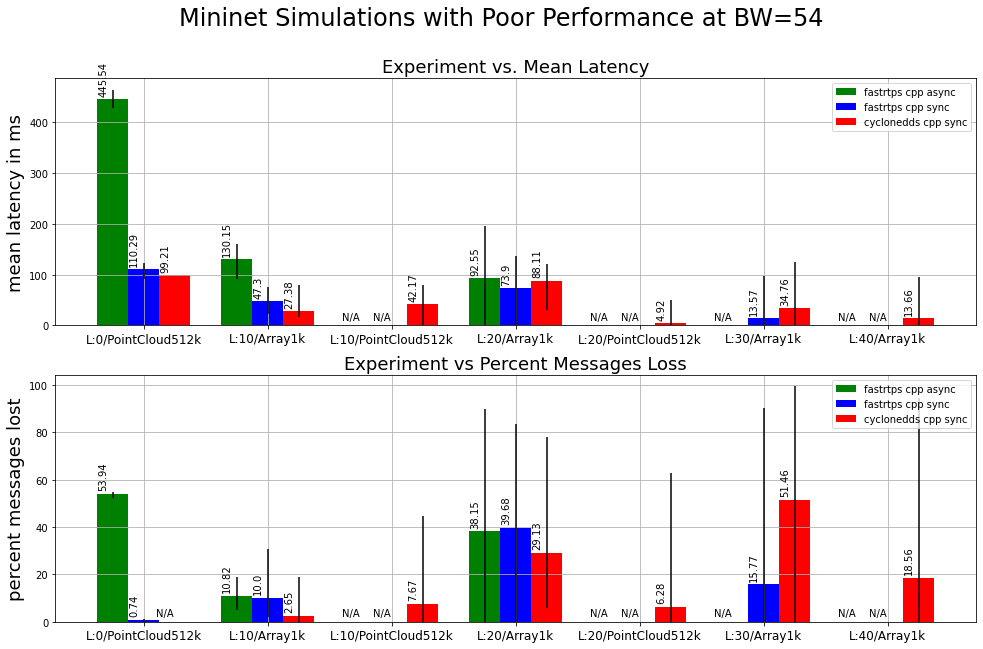

In [47]:
def autolabel(rects,ax,rot=90):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height == 0:
            name = "N/A"
            rot = 0 
        else:
            name = height
            rot = 90
        ax.annotate('{}'.format(name),
                    xy=((rect.get_x() + rect.get_width() / 2)-0.1, height+0.3),
                    xytext=(3, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize =10,
                    ha='center', va='bottom',rotation=rot)
def fixup_error(min_max,mean):
    for idx,v in enumerate(mean):
        min_max[0][idx] = v-min_max[0][idx] # min values
        min_max[1][idx] = min_max[1][idx]-v # max values 
    return min_max

def generate_mininet_plot(fast_sync_df,fast_async_df, cyclone_df, render_set,super_title):
    to_plot = ['sub_mean_latency_mean (ms)','lost_prct'] #,'mean_sub_cpu_usage (%)']
    to_std = [['sub_mean_latency_mean (ms)_min','sub_mean_latency_mean (ms)_max'],['lost_prct_min','lost_prct_max']]
    plot_units = ['mean latency in ms',"percent messages lost"]#"CPU Utilization %"]
    titles = ["Experiment vs. Mean Latency", "Experiment vs Percent Messages Loss"]#,"Experiment vs CPU Utilization %"]
    y_extents = [[0,1800],[0,110]]
    fig, ax = plt.subplots(len(to_plot))
    fig.set_size_inches(16.5,10) 
    fig.suptitle(super_title,fontsize=24)
    # for each param 
    for idx,data_point in enumerate(to_plot):
        fast_s = []
        fast_a = []
        cyclone = []
        
        # these are the min and max values not std
        fast_s_std = [[],[]]
        fast_a_std = [[],[]]
        cyclone_std = [[],[]]
        x_label = []
        # for each data point 
        for render in render_set:
            x_label.append("L:{0}/{1}".format(render[1],render[2]))
            fsv = fast_sync_df.loc[(fast_sync_df['bandwidth'] == render[0]) & 
                                   (fast_sync_df["loss"] == render[1]) & 
                                   (fast_sync_df["message_type"]==render[2])]
            fast_s.append(np.round(fsv[data_point].values[0],2))
            fast_s_std[0].append(fsv[to_std[idx][0]].values[0])
            fast_s_std[1].append(fsv[to_std[idx][1]].values[0])
            
            
            fav = fast_async_df.loc[(fast_async_df['bandwidth'] == render[0]) & 
                                    (fast_async_df["loss"] == render[1]) & 
                                    (fast_async_df["message_type"]==render[2])]
            fast_a.append(np.round(fav[data_point].values[0],2))
            fast_a_std[0].append(fav[to_std[idx][0]].values[0])
            fast_a_std[1].append(fav[to_std[idx][1]].values[0])
            
            cv = cyclone_df.loc[(cyclone_df['bandwidth'] == render[0]) & 
                                (cyclone_df["loss"] == render[1]) & 
                                (cyclone_df["message_type"] == render[2])]
            cyclone.append(np.round(cv[data_point].values[0],2))
            cyclone_std[0].append(cv[to_std[idx][0]].values[0])
            cyclone_std[1].append(cv[to_std[idx][1]].values[0])

        x = np.arange(len(render_set))
        sz = 0.25
        ax[idx].grid(which="both")

        fast_a_std = fixup_error(fast_a_std,fast_a)
        fast_s_std = fixup_error(fast_s_std,fast_s)
        cyclone_std = fixup_error(cyclone_std,cyclone)

        
        fast_a_bar = ax[idx].bar(x + 0.00, fast_a, yerr=fast_a_std, color = 'g', width = sz,label="fastrtps cpp async")
        fast_s_bar = ax[idx].bar(x + sz, fast_s, yerr=fast_s_std,color = 'b', width = sz,label="fastrtps cpp sync")
        cyclone_bar =  ax[idx].bar(x + (sz*2), cyclone,yerr=cyclone_std, color = 'r', width = sz,label="cyclonedds cpp sync")
        autolabel(fast_a_bar,ax[idx])
        autolabel(fast_s_bar,ax[idx])
        autolabel(cyclone_bar,ax[idx])
        
        #ax[idx].set_ylim(y_extents[idx])
        ax[idx].set_xticks(x+0.25)
        ax[idx].set_xticklabels(x_label,rotation=0,fontsize=12)
        ax[idx].set_ylabel(plot_units[idx],fontsize=18)
        #ax[idx].set_xlabel("Mininet Experimental Conditions")
        ax[idx].set_title(titles[idx],fontsize=18)
        ax[idx].legend()
    return fig

out = generate_mininet_plot(fast_sync_run_avg_df,fast_async_run_avg_df,cyclone_run_avg_df,bw_54,"Mininet Simulations with Poor Performance at BW=54")    
plt.savefig("./plots/PoorPerformersBW54.png")

In [48]:
fav = fast_async_df.loc[(fast_async_df['bandwidth'] == 54) & 
                        (fast_async_df["loss"] == 10) & 
                        (fast_async_df["message_type"]== "PointCloud512k")]
fav["sub_mean_latency_mean (ms)"]

230    0.0
231    0.0
232    0.0
233    0.0
234    0.0
235    0.0
236    0.0
237    0.0
238    0.0
239    0.0
Name: sub_mean_latency_mean (ms), dtype: float64

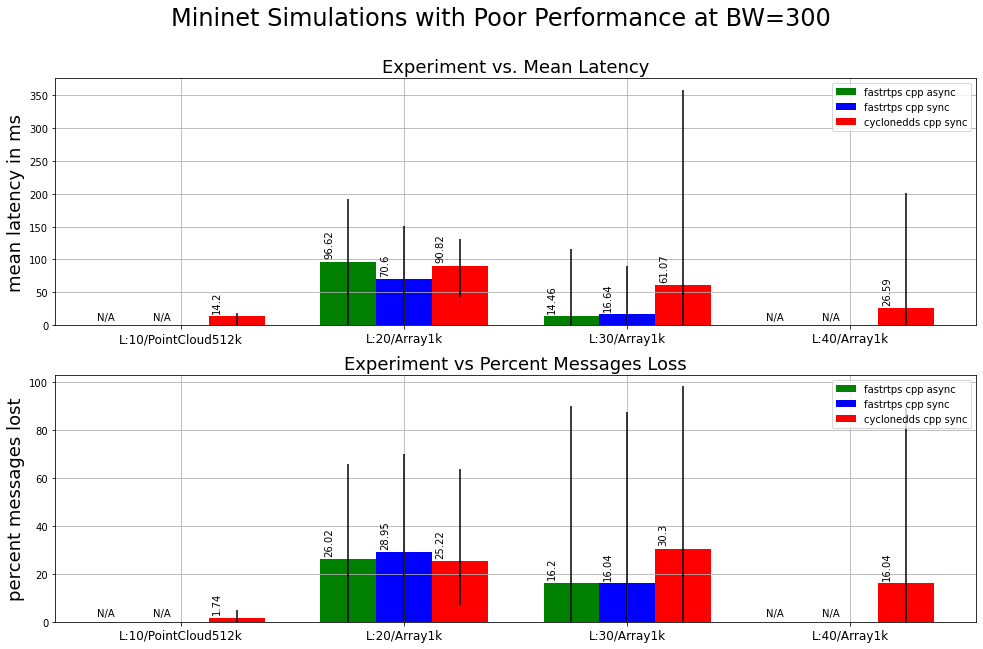

In [49]:
out = generate_mininet_plot(fast_sync_run_avg_df,fast_async_run_avg_df,cyclone_run_avg_df,bw_300,"Mininet Simulations with Poor Performance at BW=300")    
plt.savefig("./plots/PoorPerformersBW300.png")

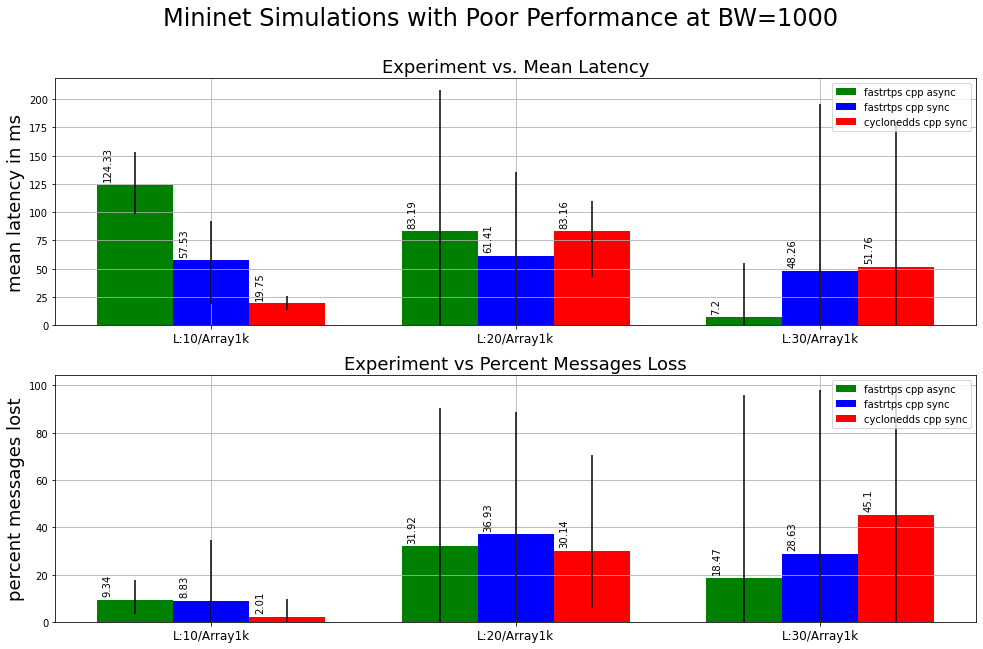

In [50]:
out = generate_mininet_plot(fast_sync_run_avg_df,fast_async_run_avg_df,cyclone_run_avg_df,bw_1000,"Mininet Simulations with Poor Performance at BW=1000")    
plt.savefig("./plots/PoorPerformersBW1000.png")

IndexError: index 0 is out of bounds for axis 0 with size 0

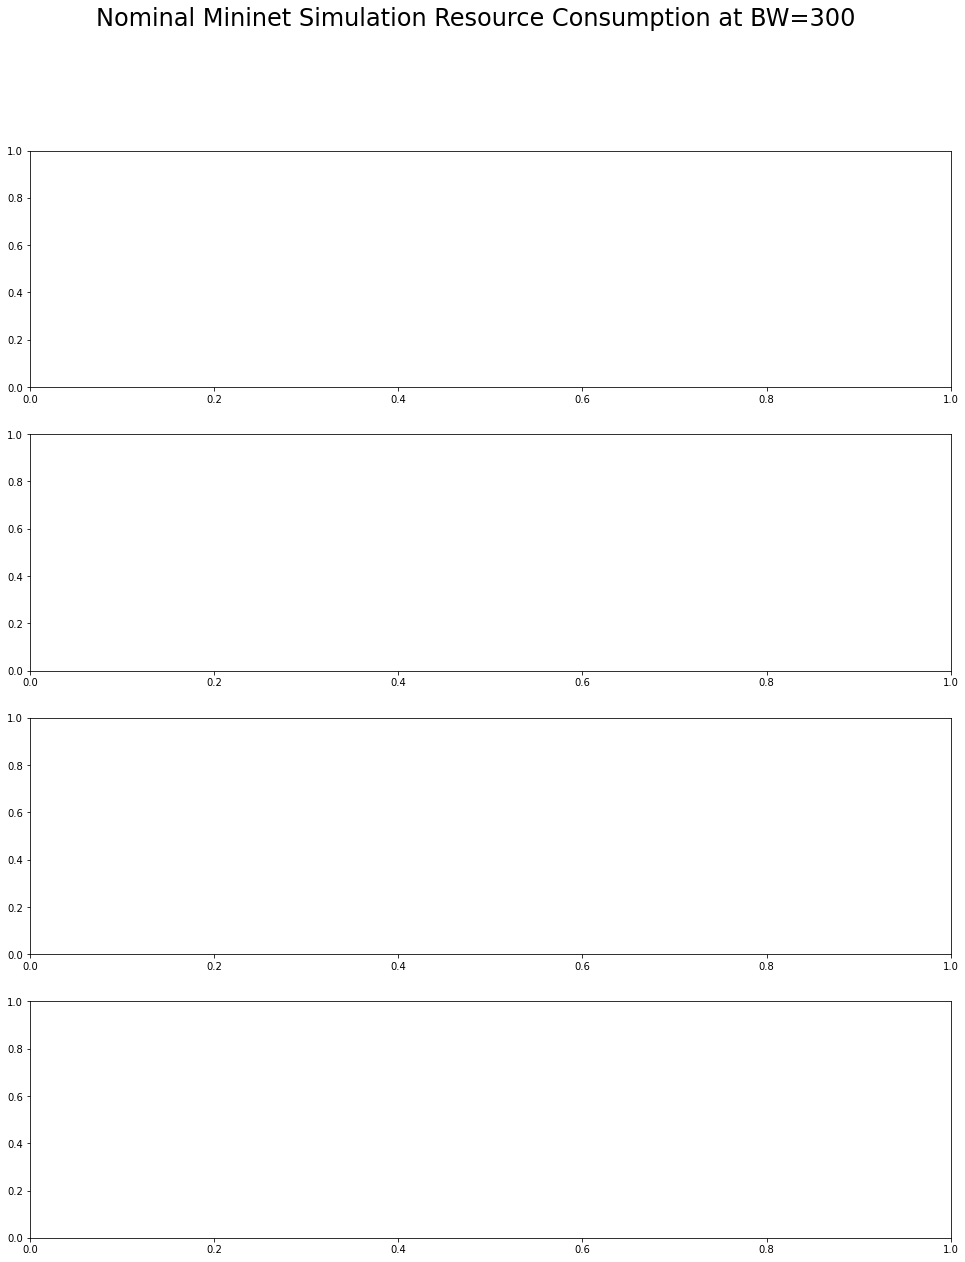

In [54]:
def generate_mininet_plot_good_conditions(fast_df, cyclone_df, render_set,super_title):
    to_plot = ['pub_mean_cpu_usage (%)','sub_mean_cpu_usage (%)',"pub_mean_ru_maxrss","sub_mean_ru_maxrss"]
    plot_units = ['Pub CPU Utilization %','Sub CPU Utilization %',"Pub ru_maxrss (memory) Kb","Sub ru_maxrss (memory) Kb"]
    titles = ["Experiment vs Pub CPU Utilization %","Experiment vs Sub CPU Utilization %","Experiment vs Pub Memory Utilization","Experiment vs Sub Memory Utilization"]
    y_extents = [[0,3],[0,3],[0,50000],[0,50000]]
    fig, ax = plt.subplots(len(to_plot))
    fig.set_size_inches(16.5,20) 
    fig.suptitle(super_title,fontsize=24)
    for idx,data_point in enumerate(to_plot):
        fast = []
        cyclone = [] 
        x_label = []
        for render in render_set:
            x_label.append("L:{0}/{1}".format(render[1],render[2]))
            fv = fast_df.loc[(fast_df['bandwidth'] == render[0]) & (fast_df["loss"] == render[1]) & (fast_df["message_type"]==render[2])]
            fast.append(fv[data_point].values[0])
            cv = cyclone_df.loc[(cyclone_df['bandwidth'] == render[0]) & 
                                (cyclone_df["loss"] == render[1]) & 
                                (cyclone_df["message_type"] == render[2])]
            cyclone.append(cv[data_point].values[0])
            
        x = np.arange(len(render_set))
        sz = 0.33
        ax[idx].grid(which="both")
        ax[idx].bar(x + 0.00, fast, color = 'b', width = sz,label="FastRTPS")
        ax[idx].bar(x + sz, cyclone, color = 'g', width = sz,label="Cyclone")
        ax[idx].set_ylim(y_extents[idx])
        ax[idx].set_xticks(x)
        ax[idx].set_xticklabels(x_label,rotation=0,fontsize=14)
        ax[idx].set_ylabel(plot_units[idx],fontsize=16)
        #ax[idx].set_xlabel("Mininet Experimental Conditions")
        ax[idx].set_title(titles[idx],fontsize=18)
        ax[idx].legend()
    return fig

good_examples = [
    (300,20,'Array1k'),
    (300,20,'PointCloud512k'),
    (300,20,'Array1m'),
    (300,20,'PointCloud2m')]
out = generate_mininet_plot_good_conditions(fast_df,cyclone_df,good_examples,"Nominal Mininet Simulation Resource Consumption at BW=300")    
plt.savefig("GoodBW300.png")

In [ ]:
bw_54

In [ ]:
bw_300_ok = [
    (300,20,'Array1k'),
    (300,20,'PointCloud512k'),
    (300,20,'Array1m'),
    (300,20,'PointCloud2m')
]

In [ ]:
set(cyclone_df["message_type"].tolist())